## EDS Project - HR Employee Attrition Prediction

### Import required libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling  import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve,auc
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Loading Dataset

In [2]:
employee = pd.read_csv('EmployeeAttrition.csv')

#loading to another variable for possible statistical analysis to avoid conflict.
employeeA = pd.read_csv('EmployeeAttrition.csv')

employee.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


#### Categorical Variables for my own reference :

```Python
Education 
1 'Below College' 2 'College' 3 'Bachelor' 4 'Master' 5 'Doctor'
EnvironmentSatisfaction 
1 'Low' 2 'Medium' 3 'High' 4 'Very High'
JobInvolvement 
1 'Low' 2 'Medium' 3 'High' 4 'Very High'
JobSatisfaction 
1 'Low' 2 'Medium' 3 'High' 4 'Very High'
PerformanceRating 
1 'Low' 2 'Good' 3 'Excellent' 4 'Outstanding'
RelationshipSatisfaction 
1 'Low' 2 'Medium' 3 'High' 4 'Very High'
WorkLifeBalance 
1 'Bad' 2 'Good' 3 'Better' 4 'Best'
BusinessTravel
'Non_Travel' 'Travel_Rarely' 'Travel_Frequently' 
Department
'Sales' 'R&D' 'HR'
Gender
'Males' 'Female'
EducationField
'HR' 'Life Science' 'Marketing' 'Medical' 'Other' 'Technical Degree'
Overtime
'Yes' 'No'
MaritialStatus
'Divorced' 'Single' 'Married'
```

## Data Exploration 

### Data Quality checking..?
Check for null values...constants... etc.

In [3]:
#check for null values
employee.isnull().any()

#check for constants.
employee.nunique()==1 

#checking the number of unique values.
employee.nunique()

print()

### About income-related attributes

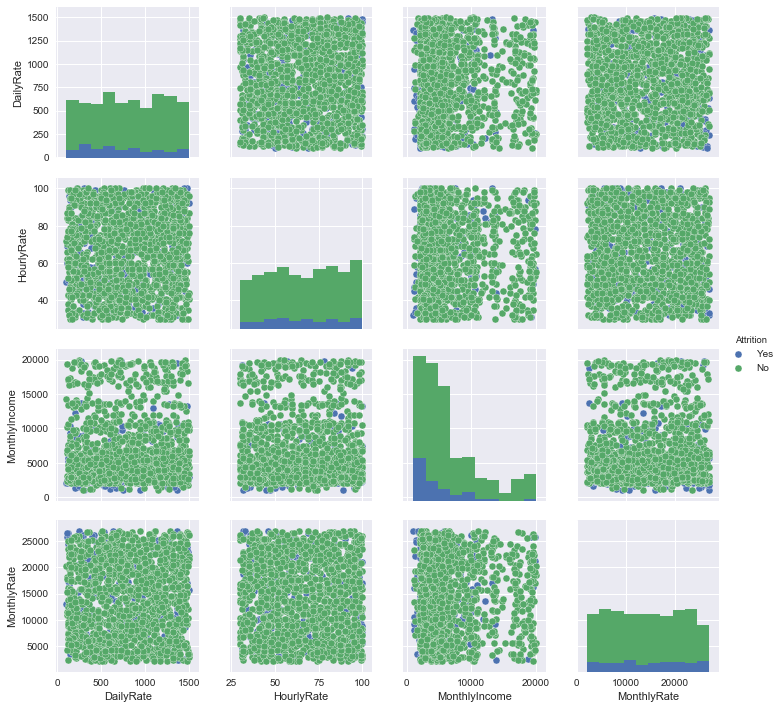

In [4]:
#awared that there is 4 income-related attributes. Which one is really affecting attrition?

sns.pairplot(data=employeeA[['Attrition','DailyRate','HourlyRate','MonthlyIncome','MonthlyRate']],
             hue='Attrition')

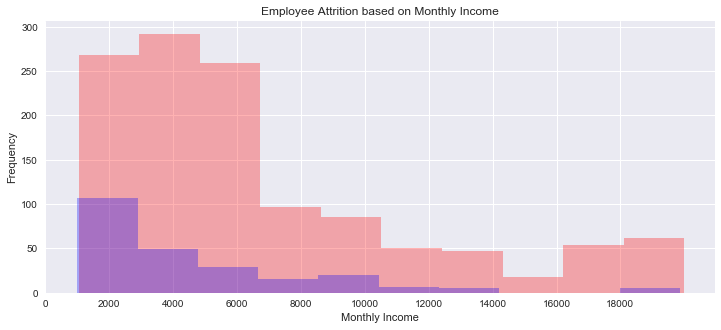

In [5]:
# Analyzing attrition trends againsts non-categorical factors.
# splitting the minor and major classes.
attrition_yes = employee.loc[employee['Attrition'] == 'Yes']
attrition_no = employee.loc[employee['Attrition'] == 'No']
attrition_no.shape

plt.figure(figsize=(12,5))
plt.hist(attrition_no['MonthlyIncome'],bins=10, color='r',alpha=0.3, histtype='stepfilled')
plt.hist(attrition_yes['MonthlyIncome'],bins=10,color='b',alpha=0.3, histtype='stepfilled')
plt.title('Employee Attrition based on Monthly Income')
plt.xticks(range(0,20000,2000))
plt.xlabel('Monthly Income')
plt.ylabel('Frequency')

### Data preprocessing

#### Check to see if data is imbalanced

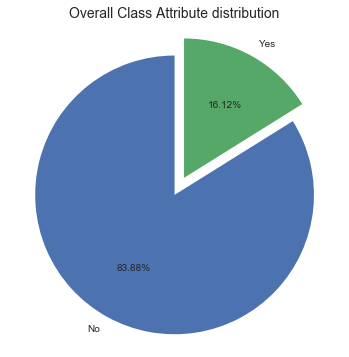

In [54]:
fig1, ax1 = plt.subplots(figsize=(6,6))
## check to see if dataset is balanced.

plt.title('Overall Class Attribute distribution', fontsize=14)
ax1.pie(employee['Attrition'].value_counts(),  autopct='%1.2f%%', explode=(0,0.14),
        labels=['No','Yes'],startangle=90)
ax1.axis('equal') 

plt.show()

In [7]:
#categorical attributes.
strCatVarList = ['Attrition','BusinessTravel','Department','Gender','EducationField','OverTime','MaritalStatus',
             'JobRole']

numCatVarList = ['Education','EnvironmentSatisfaction','JobInvolvement','JobSatisfaction',
                'PerformanceRating','RelationshipSatisfaction','WorkLifeBalance']


#instantiate LabelEncoder instance.
encoder = LabelEncoder()

for n in strCatVarList:
    employee[n] = encoder.fit_transform(employee[n])
    
for m in numCatVarList:
    employee[m] = employee[m].astype('category')

#### Train and Test set splitting

In [8]:
#drop constants and unnecessary columns.

X = employee.drop(['Attrition','EmployeeCount','EmployeeNumber','Over18','StandardHours',
                   'HourlyRate','DailyRate','MonthlyRate'],axis=1)#.values
y = employee['Attrition']

In [9]:
#splitting into train and testing sets.

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 2)

#### Imbalanced dataset handling
From above the result shows the dataset is skewed. Only 16.1% of the employee left while 83.9% stayed.

In [10]:
# oversampling technique.
smote = SMOTE(random_state=2)
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)

# undersampling technique.
rus = RandomUnderSampler(random_state=2)
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

In [11]:
scaler = MinMaxScaler()

#minmaxScaler
X_train_smote_S = scaler.fit_transform(X_train_smote)
X_test_S = scaler.transform(X_test)

X_train_rus_S = scaler.fit_transform(X_train_rus)
X_train_S = scaler.fit_transform(X_train)

## Classification Models

### General Function



In [15]:
usedModels = ['LogReg', 'KNN','SVM','GaussianNB','RandomForest','DecisionTree','GradBoost_DT','NeuralNetwork']


SMOTE_acc = []
RUS_acc = []
ORI_acc = []
SMOTE_AUC = []
RUS_AUC = []
ORI_AUC = []

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

def show_result(model, X_smote, X_rus, X_train, X_test, y_smote, y_rus, y_test, y_train):
    
    clf = model.fit(X_smote,y_smote)
    y_pred = clf.predict(X_test)
    
    clf2 = model.fit(X_rus, y_rus)
    y_pred2 = clf2.predict(X_test)
    
    clf3 = model.fit(X_train, y_train)
    y_pred3 = clf3.predict(X_test)
    
    print("SMOTE Accuracy : {:.4f}".format(accuracy_score(y_test,y_pred)))
    SMOTE_acc.append(round(accuracy_score(y_test,y_pred),4))
    
    print("RUS Accuracy : {:.4f}".format(accuracy_score(y_test,y_pred2)))
    RUS_acc.append(round(accuracy_score(y_test,y_pred2),4))
    
    print("Original Accuracy : {:.4f}".format(accuracy_score(y_test,y_pred3)))
    ORI_acc.append(round(accuracy_score(y_test,y_pred3),4))

    # plotting confusion matrix
    fig, axes = plt.subplots(1,3,figsize=(11,11))
    plt.subplot(1,3,1) 
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.title('SMOTE Method', fontsize=16)
    plt.xlabel('true label', fontsize=13)
    plt.ylabel('predicted label', fontsize=13);

    plt.subplot(1,3,2) 
    mat = confusion_matrix(y_test, y_pred2)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.title('RUS Method', fontsize=16)
    plt.xlabel('true label', fontsize=13)
    plt.ylabel('predicted label', fontsize=13);

    plt.subplot(1,3,3) 
    mat = confusion_matrix(y_test, y_pred3)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.title('Original Data', fontsize=16)
    plt.xlabel('true label', fontsize=13)
    plt.ylabel('predicted label', fontsize=13);

    fig.tight_layout()
    
    return y_test, y_pred, y_pred2, y_pred3
    #plotting AUC ROC curve


In [17]:
def roc_auc_curve(ytest, ypred, ypred2, ypred3):
    
    fig,axes = plt.subplots(3,1,figsize=(10,10))
    
    auc_roc_smote = roc_auc_score(ytest, ypred)
    SMOTE_AUC.append(round(auc_roc_smote,4))
    fpr_smote, tpr_smote, thresholds = roc_curve(ytest, ypred)
    
    auc_roc_rus = roc_auc_score(ytest, ypred2)
    RUS_AUC.append(round(auc_roc_rus,4))
    fpr_rus, tpr_rus, thresholds = roc_curve(ytest, ypred2)
    
    auc_roc = roc_auc_score(ytest, ypred3)
    ORI_AUC.append(round(auc_roc,4))
    fpr, tpr, thresholds = roc_curve(ytest, ypred3)
    
    plt.subplot(3,1,1) 
    plt.title('ROC Curve for SMOTE',fontsize=16)
    plt.plot(fpr_smote,tpr_smote, color='red',label = 'AUC = %0.4f' % auc_roc_smote)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.ylabel('True Positive Rate',fontsize=13)
    plt.xlabel('False Positive Rate',fontsize=13)
    
    plt.subplot(3,1,2) 
    plt.title('ROC Curve for RUS',fontsize=16)
    plt.plot(fpr_rus,tpr_rus, color='red',label = 'AUC = %0.4f' % auc_roc_rus)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.ylabel('True Positive Rate',fontsize=13)
    plt.xlabel('False Positive Rate',fontsize=13)
    
    plt.subplot(3,1,3) 
    plt.title('ROC Curve for Original Data', fontsize=16)
    plt.plot(fpr,tpr, color='red',label = 'AUC = %0.4f' % auc_roc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.ylabel('True Positive Rate',fontsize=13)
    plt.xlabel('False Positive Rate',fontsize=13)

    fig.tight_layout()

### Logistic Regression

SMOTE Accuracy : 0.7500
RUS Accuracy : 0.7310
Original Accuracy : 0.8696


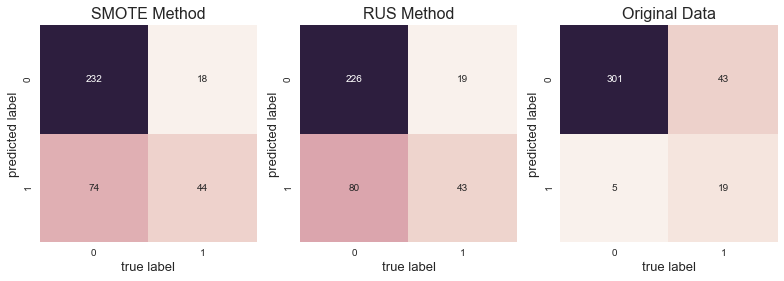

In [18]:
from sklearn.linear_model import LogisticRegression


log_reg = LogisticRegression(C=15, tol=0.01, solver='sag')

y_test1, y_pred_1, y_pred2_1, y_pred3_1 = \
show_result(log_reg, X_train_smote_S, X_train_rus_S, X_train_S, X_test_S, y_train_smote, y_train_rus, y_test, y_train)

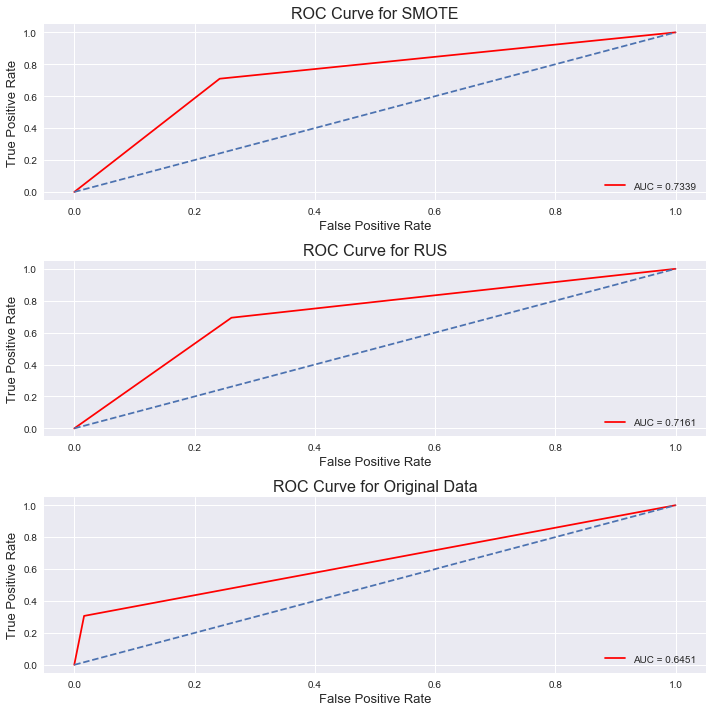

In [19]:
roc_auc_curve(y_test1, y_pred_1, y_pred2_1, y_pred3_1)

### KNN

SMOTE Accuracy : 0.7310
RUS Accuracy : 0.7826
Original Accuracy : 0.8397


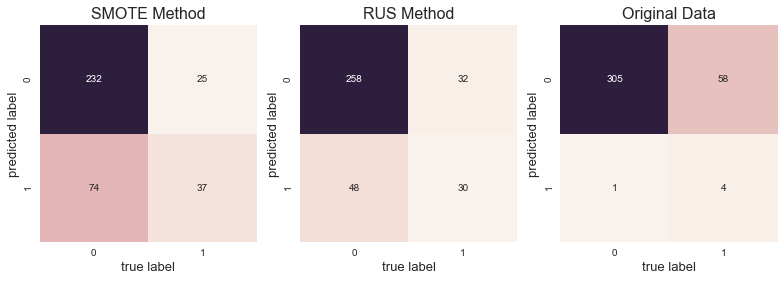

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 6)

y_test1, y_pred_1, y_pred2_1, y_pred3_1 = \
show_result(knn, X_train_smote_S, X_train_rus_S, X_train_S, X_test_S, y_train_smote, y_train_rus, y_test, y_train)

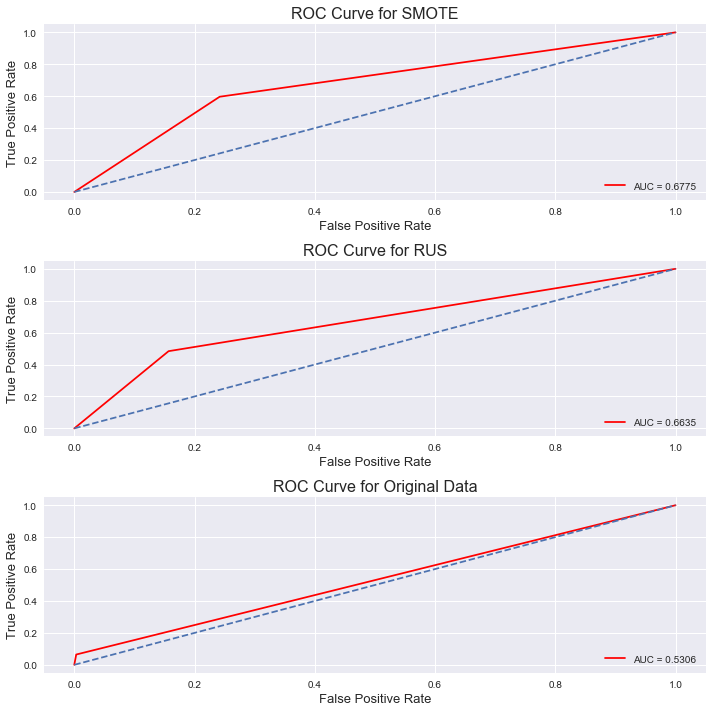

In [21]:
roc_auc_curve(y_test1, y_pred_1, y_pred2_1, y_pred3_1)

### Support Vector Machine (SVM)

SMOTE Accuracy : 0.8098
RUS Accuracy : 0.7717
Original Accuracy : 0.8614


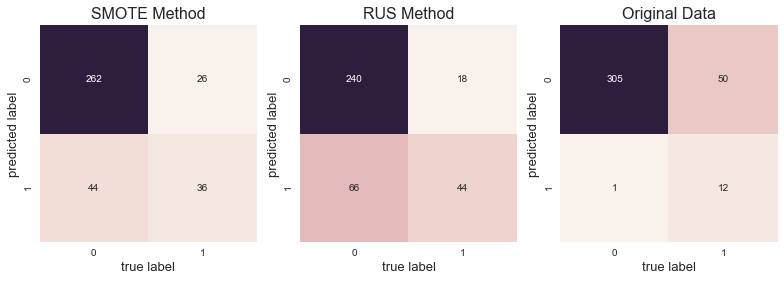

In [22]:
from sklearn.svm import SVC

svm = SVC(C=8)
y_test1, y_pred_1, y_pred2_1, y_pred3_1 = \
show_result(svm, X_train_smote_S, X_train_rus_S, X_train_S, X_test_S, y_train_smote, y_train_rus, y_test, y_train)

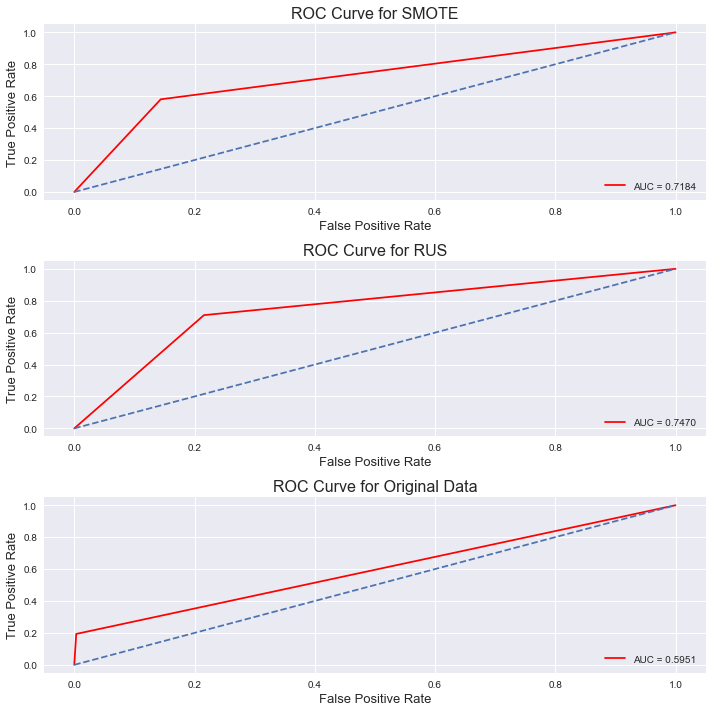

In [23]:
roc_auc_curve(y_test1, y_pred_1, y_pred2_1, y_pred3_1)

### Naive Bayes Classifier

SMOTE Accuracy : 0.6630
RUS Accuracy : 0.6793
Original Accuracy : 0.8424


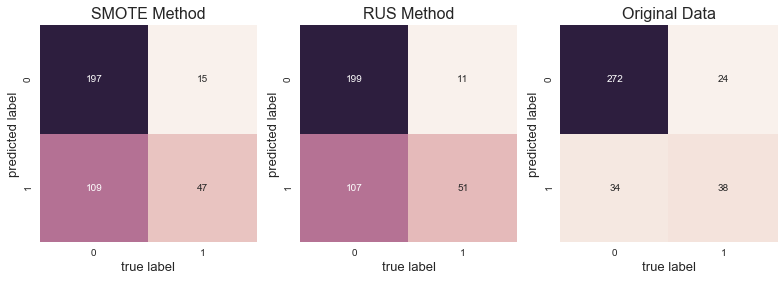

In [24]:
from sklearn.naive_bayes import GaussianNB

nbclf = GaussianNB()

y_test1, y_pred_1, y_pred2_1, y_pred3_1 = \
show_result(nbclf, X_train_smote_S, X_train_rus_S, X_train_S, X_test_S, y_train_smote, y_train_rus, y_test, y_train)

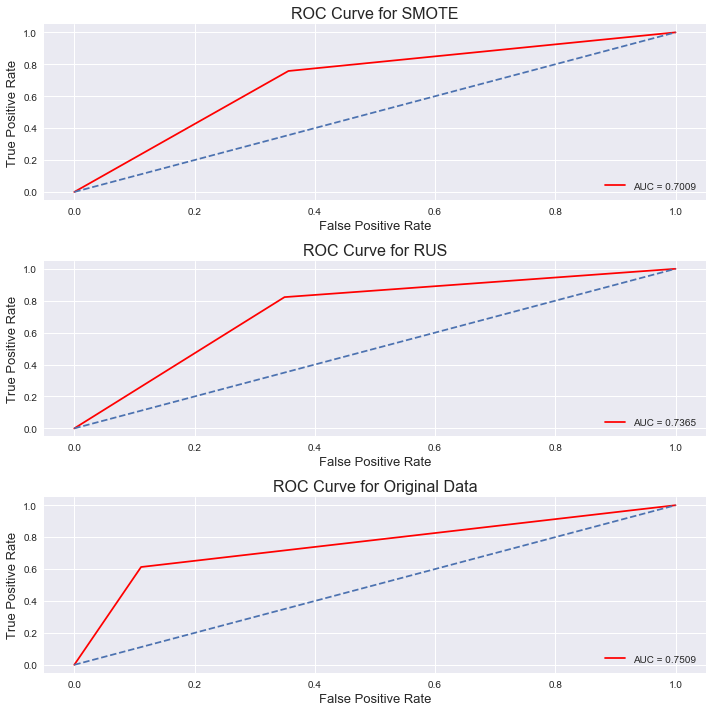

In [25]:
roc_auc_curve(y_test1, y_pred_1, y_pred2_1, y_pred3_1)

### Random Forest

SMOTE Accuracy : 0.8505
RUS Accuracy : 0.7065
Original Accuracy : 0.8451


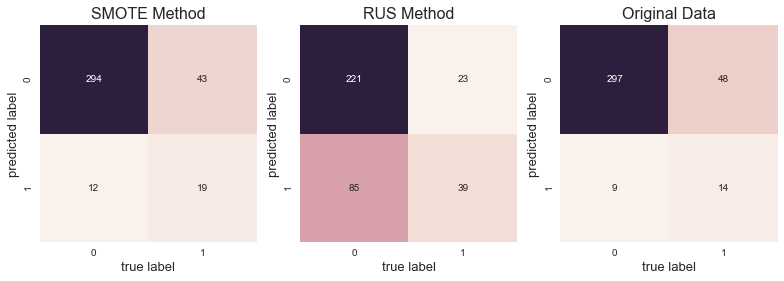

In [26]:
from sklearn.ensemble import RandomForestClassifier

rfclf = RandomForestClassifier(n_estimators = 25, random_state=0)

y_test1, y_pred_1, y_pred2_1, y_pred3_1 = \
show_result(rfclf, X_train_smote_S, X_train_rus_S, X_train_S, X_test_S, y_train_smote, y_train_rus, y_test, y_train)

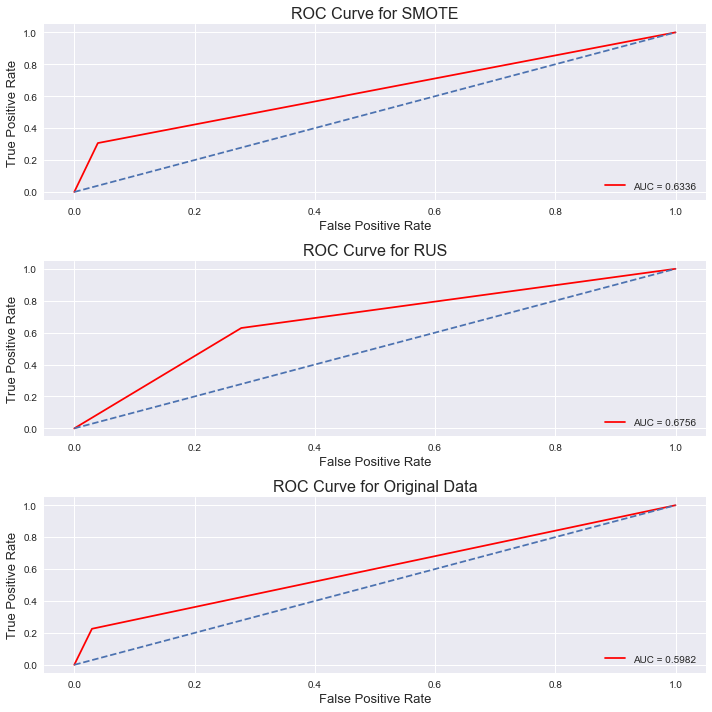

In [27]:
roc_auc_curve(y_test1, y_pred_1, y_pred2_1, y_pred3_1)

### Decision Tree Classifier

SMOTE Accuracy : 0.8043
RUS Accuracy : 0.6141
Original Accuracy : 0.8071


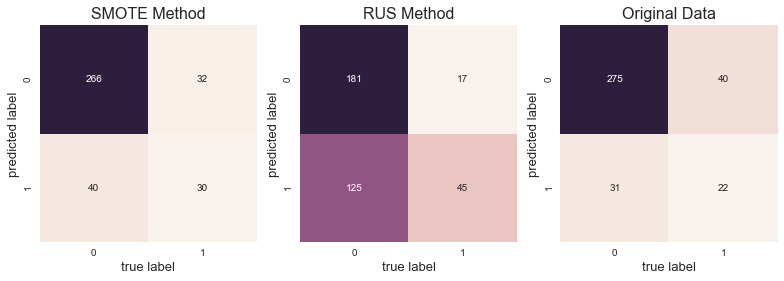

In [28]:
from sklearn.tree import DecisionTreeClassifier

dfclf = DecisionTreeClassifier(random_state=0)

y_test1, y_pred_1, y_pred2_1, y_pred3_1 = \
show_result(dfclf, X_train_smote_S, X_train_rus_S, X_train_S, X_test_S, y_train_smote, y_train_rus, y_test, y_train)

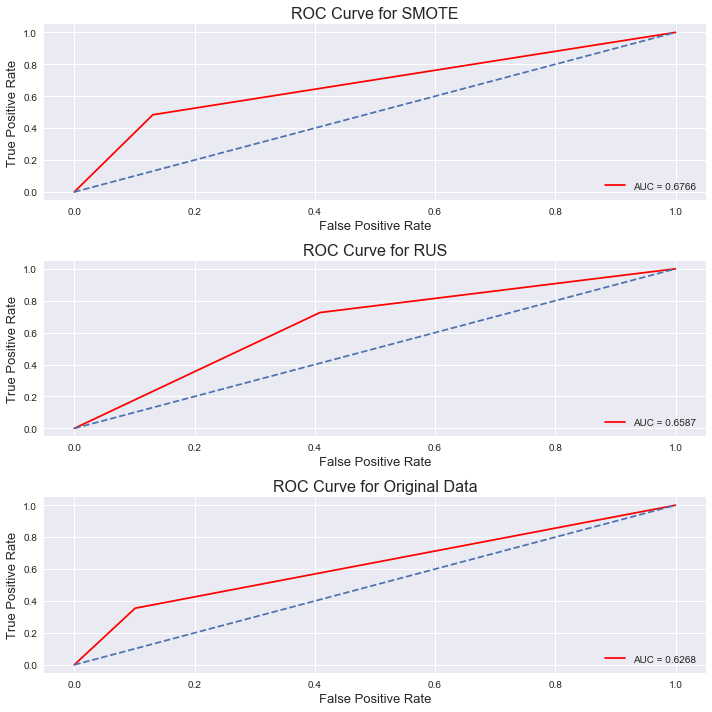

In [29]:
roc_auc_curve(y_test1, y_pred_1, y_pred2_1, y_pred3_1)

### GRADIENT boosted Decision Tree

SMOTE Accuracy : 0.8668
RUS Accuracy : 0.7310
Original Accuracy : 0.8533


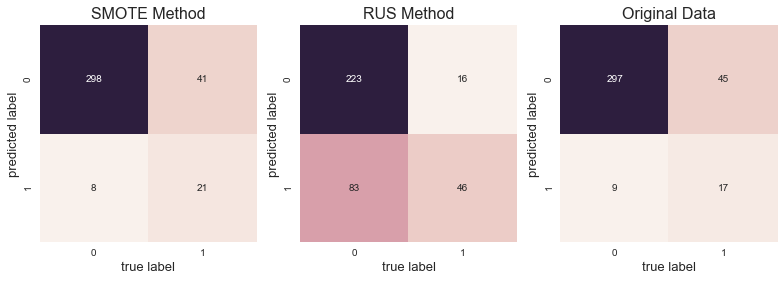

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

dtclf = GradientBoostingClassifier(learning_rate = 0.11, random_state=0)

y_test1, y_pred_1, y_pred2_1, y_pred3_1 = \
show_result(dtclf, X_train_smote_S, X_train_rus_S, X_train_S, X_test_S, y_train_smote, y_train_rus, y_test, y_train)

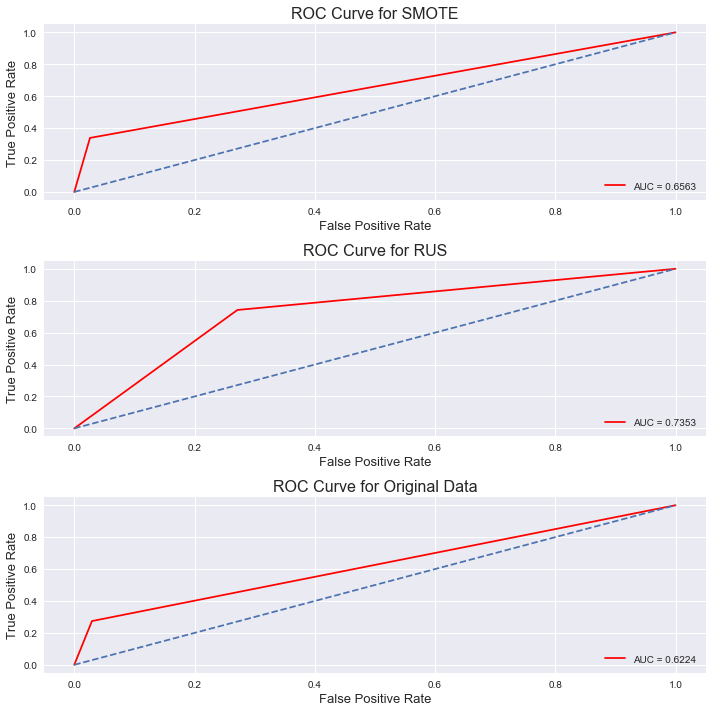

In [31]:
roc_auc_curve(y_test1, y_pred_1, y_pred2_1, y_pred3_1)

### Neural Network

SMOTE Accuracy : 0.8397
RUS Accuracy : 0.7745
Original Accuracy : 0.8723


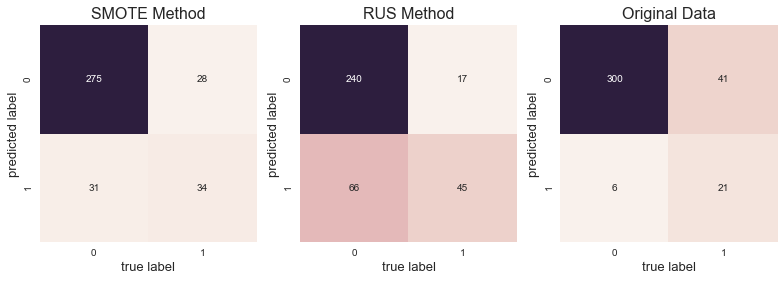

In [32]:
from sklearn.neural_network import MLPClassifier

nnclf = MLPClassifier(alpha = 5.0,random_state = 0, solver='lbfgs')
y_test1, y_pred_1, y_pred2_1, y_pred3_1 = \
show_result(nnclf, X_train_smote_S, X_train_rus_S, X_train_S, X_test_S, y_train_smote, y_train_rus, y_test, y_train)

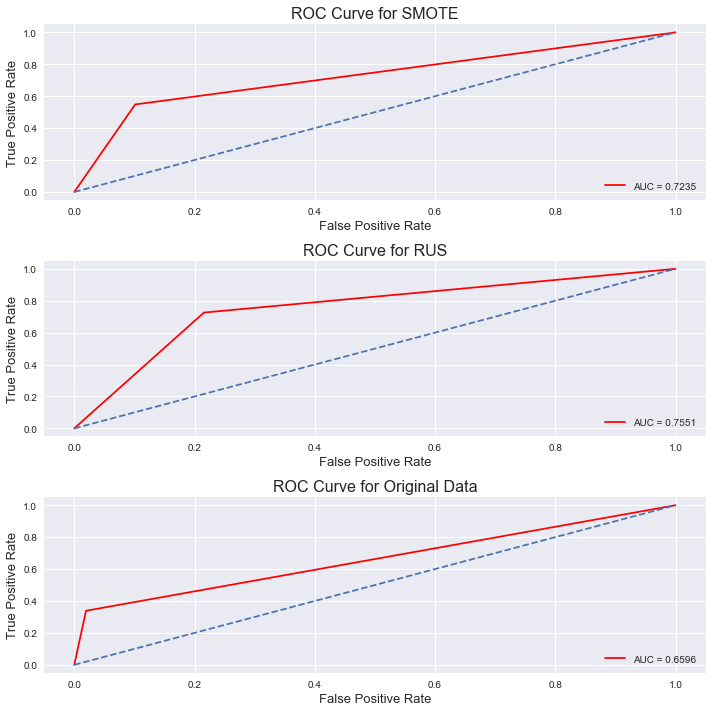

In [33]:
roc_auc_curve(y_test1, y_pred_1, y_pred2_1, y_pred3_1)

## Results Analysis

In [40]:
results = pd.DataFrame({ "SMOTE Accuracy" : SMOTE_acc ,
                    "RUS Accuracy" : RUS_acc,
                    'Original Accuracy': ORI_acc,
                    'SMOTE AUC': SMOTE_AUC,
                    'RUS AUC': RUS_AUC,
                    'Original AUC': ORI_AUC}, index=usedModels)

results

,Original AUC,Original Accuracy,RUS AUC,RUS Accuracy,SMOTE AUC,SMOTE Accuracy
LogReg,0.6451,0.8696,0.7161,0.7310,0.7339,0.7500
KNN,0.5306,0.8397,0.6635,0.7826,0.6775,0.7310
SVM,0.5951,0.8614,0.7470,0.7717,0.7184,0.8098
GaussianNB,0.7509,0.8424,0.7365,0.6793,0.7009,0.6630
RandomForest,0.5982,0.8451,0.6756,0.7065,0.6336,0.8505
DecisionTree,0.6268,0.8071,0.6587,0.6141,0.6766,0.8043
GradBoost_DT,0.6224,0.8533,0.7353,0.7310,0.6563,0.8668
NeuralNetwork,0.6596,0.8723,0.7551,0.7745,0.7235,0.8397


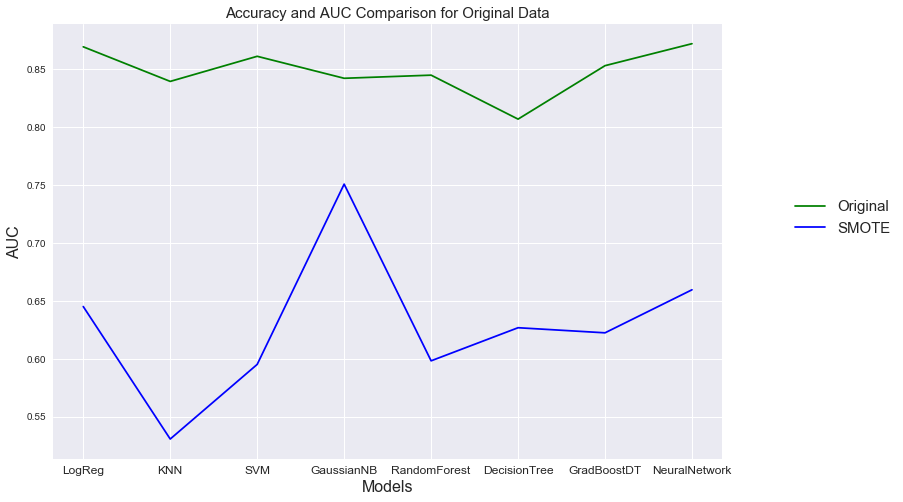

In [50]:
%matplotlib inline

X = results.index
index1 = np.arange(len(X))

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(index1, results['Original Accuracy'], color="green")
ax.plot(index1, results['Original AUC'], color="blue")
# ax.plot(index1, results['RUS AUC'], color="red")
ax.legend(['Original','SMOTE','RUS'],loc=[1.1,0.5], fontsize=15)
ax.set_xlabel('Models', fontsize=16)
ax.set_ylabel('AUC', fontsize=16)
ax.set_title('Accuracy and AUC Comparison for Original Data', fontsize=15)
ax.set_xticklabels(['','LogReg','KNN','SVM','GaussianNB','RandomForest','DecisionTree',
                    'GradBoostDT','NeuralNetwork'], fontsize=12)

plt.show()

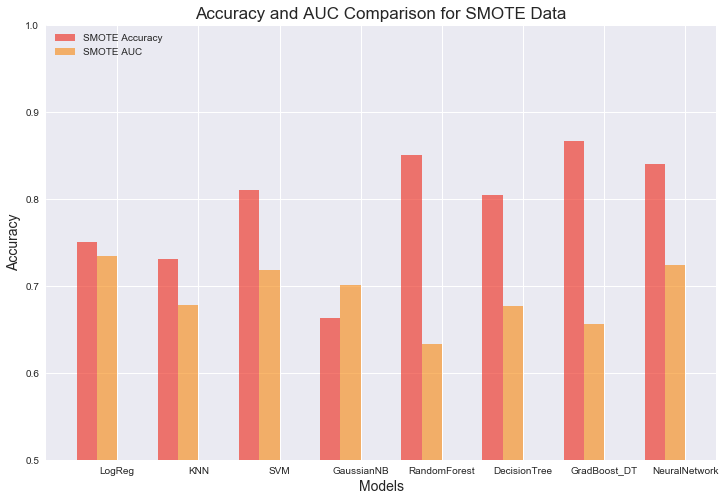

In [48]:
# Setting the positions and width for the bars
pos = list(range(len(results['Original Accuracy']))) 
width = 0.25

# Plotting the bars
fig, ax = plt.subplots(figsize=(12,8))

plt.bar(pos,  results['SMOTE Accuracy'],  width,  color='#EE3224', alpha=0.65) 
plt.bar([p + width for p in pos], results['SMOTE AUC'], width, color='#F78F1E', alpha=0.65) 
# plt.bar([p + width*2 for p in pos],  results['Original Accuracy'], width,  color='#FFC222', alpha=0.65) 

ax.set_ylabel('Accuracy',fontsize=14)
ax.set_xlabel('Models',fontsize=14)
ax.set_title('Accuracy and AUC Comparison for SMOTE Data', fontsize=17)
ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels(results.index)
plt.ylim([0.5,1.0] )

plt.legend(['SMOTE Accuracy', 'SMOTE AUC'], loc='upper left')

plt.show()

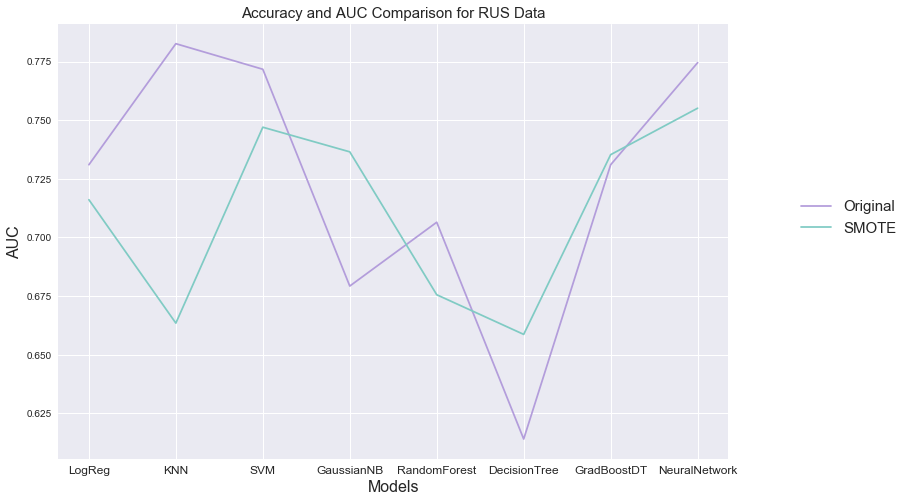

In [53]:
%matplotlib inline

X = results.index
index1 = np.arange(len(X))

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(index1, results['RUS Accuracy'], color="#B39DDB")
ax.plot(index1, results['RUS AUC'], color="#80CBC4")
# ax.plot(index1, results['RUS AUC'], color="red")
ax.legend(['Original','SMOTE','RUS'],loc=[1.1,0.5], fontsize=15)
ax.set_xlabel('Models', fontsize=16)
ax.set_ylabel('AUC', fontsize=16)
ax.set_title('Accuracy and AUC Comparison for RUS Data', fontsize=15)
ax.set_xticklabels(['','LogReg','KNN','SVM','GaussianNB','RandomForest','DecisionTree',
                    'GradBoostDT','NeuralNetwork'], fontsize=12)

plt.show()

In [37]:
results.describe()

,Original AUC,Original Accuracy,RUS AUC,RUS Accuracy,SMOTE AUC,SMOTE Accuracy
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,0.628587,0.848863,0.710975,0.723837,0.690087,0.789388
std,0.063113,0.020840,0.039192,0.056996,0.035106,0.069521
min,0.530600,0.807100,0.658700,0.614100,0.633600,0.663000
25%,0.597425,0.841725,0.672575,0.699700,0.671525,0.745250
50%,0.624600,0.849200,0.725700,0.731000,0.689200,0.807050
75%,0.648725,0.863450,0.739125,0.772400,0.719675,0.842400
max,0.750900,0.872300,0.755100,0.782600,0.733900,0.866800
